<a href="https://colab.research.google.com/github/victorbahlangene/fastai-fastbook22/blob/main/PyTorch_Tutorial_13_Feed_Forward_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## Device Config

In [2]:
# torch.device??

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cpu')

## Hyper-parameters

In [5]:
input_size = 784 # 28*28
hidden_size = 500
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

# MNIST

**Train**

In [6]:
# torchvision.datasets.MNIST??

In [7]:
train_dset = torchvision.datasets.MNIST(root = "./data",
                                        train = True,
                                        transform=transforms.ToTensor(),
                                        download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
train_dset.data.shape

torch.Size([60000, 28, 28])

In [9]:
test_dset = torchvision.datasets.MNIST(root = "./data",
                                        train = False,
                                        transform=transforms.ToTensor())

In [10]:
test_dset.data.shape

torch.Size([10000, 28, 28])

# Dataloader, Transformation

In [11]:
# torch.utils.data.DataLoader??

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_dset,
                                           batch_size=batch_size,
                                           shuffle=True)

In [13]:
test_loader = torch.utils.data.DataLoader(dataset=test_dset,
                                           batch_size=batch_size,
                                           shuffle=False)

## View in DataLoader

In [14]:
len(test_loader)

100

In [15]:
iter(test_loader)

Similar to fastai `dls.show_batch()`

In [16]:
examples = iter(test_loader)
example_data, example_targets = examples.next()

In [17]:
example_data.shape, example_targets.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

In [18]:
example_data[0].shape

torch.Size([1, 28, 28])

In [19]:
example_data[0][0].shape

torch.Size([28, 28])

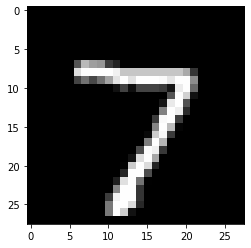

In [20]:
img = example_data[0][0]
plt.imshow(img, cmap="gray")

same as fastai `dls.show_batch(n=6)`

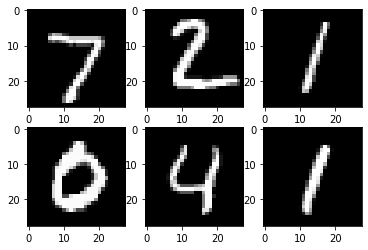

In [21]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(example_data[i][0], cmap="gray")
plt.show()

# Multilayer Neural Net, activation function

**Fully connected neural network with one hidden layer**

In [22]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.input_size = input_size
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    # no activation and no softmax at the end
    return out

In [23]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

In [24]:
model

NeuralNet(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=10, bias=True)
)

# Loss and Optimizer

In [25]:
# torch.optim.Adam??

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
criterion

CrossEntropyLoss()

In [28]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

# Training Loop (batch training)

- number of images in training dataloader = 6000
- batch size = 100
- number of batches = 600

In [29]:
n_total_steps = len(train_loader)
n_total_steps

600

In [30]:
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [100, 1, 28, 28]
    # resized: [100, 784]
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)

    # Forward pass #
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and optimize #
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.3337
Epoch [1/2], Step [200/600], Loss: 0.2579
Epoch [1/2], Step [300/600], Loss: 0.1713
Epoch [1/2], Step [400/600], Loss: 0.2106
Epoch [1/2], Step [500/600], Loss: 0.1584
Epoch [1/2], Step [600/600], Loss: 0.1120
Epoch [2/2], Step [100/600], Loss: 0.1665
Epoch [2/2], Step [200/600], Loss: 0.2962
Epoch [2/2], Step [300/600], Loss: 0.1065
Epoch [2/2], Step [400/600], Loss: 0.0939
Epoch [2/2], Step [500/600], Loss: 0.0807
Epoch [2/2], Step [600/600], Loss: 0.0716


# Model evaluation

Test the model

In test phase, we don't need to compute gradients (for memory efficiency)

In [31]:
for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)

In [33]:
images.shape

torch.Size([100, 784])

In [34]:
labels.shape

torch.Size([100])

In [35]:
outputs.shape

torch.Size([100, 10])

In [38]:
outputs.data.shape

torch.Size([100, 10])

In [39]:
torch.max(outputs.data)

tensor(15.1921)

In [40]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([ 6.1131,  5.6646,  7.1688,  5.2432,  1.6694,  2.9967,  3.8869,  5.3793,
         8.9384, 10.0141,  6.1597,  9.2570,  5.8559,  5.9541,  5.9532,  5.7908,
         6.4835,  9.9391,  6.5570,  8.9544,  8.3453,  5.6339,  2.6196,  7.3909,
         5.9156,  2.2338,  4.6682,  4.4194,  5.5499,  7.6854,  8.9670,  6.0088,
         7.3094,  9.0115,  7.6287,  8.5687,  6.2974,  7.0376,  8.4693, 10.3962,
         3.9331,  2.3744,  9.6993,  3.7423,  3.6869,  7.5498,  5.7001,  6.8046,
         9.7047,  7.8685,  6.1244,  7.5396, 12.3164,  4.1362,  5.4219,  4.7052,
         6.5893,  7.8791,  7.9149,  2.7923,  8.5479,  8.1337,  7.1959,  8.1167,
         6.6582,  7.7711,  7.7856,  6.5268,  9.8525,  6.6708,  6.5755,  4.9025,
         9.1232,  7.5911,  7.4769,  2.5823,  5.0327,  5.8710,  7.1845,  9.3578,
         6.3787,  6.5845,  3.0971, 15.1921,  5.3982,  9.4751,  5.0149,  9.0392,
        10.6167, 12.3935, 12.0490, 10.4995,  8.3170, 10.9174,  6.4749, 11.8671,
         

In [41]:
test_vals, predicted = torch.max(outputs.data, 1)

In [42]:
test_vals.shape, predicted.shape

(torch.Size([100]), torch.Size([100]))

In [44]:
labels.size()

torch.Size([100])

In [45]:
labels.size(0)

100

In [48]:
n_samples = labels.size(0)
n_samples

100

In [49]:
(predicted == labels)

tensor([ True,  True,  True,  True, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True])

In [50]:
(predicted == labels).sum()

tensor(93)

In [51]:
(predicted == labels).sum().item()

93

In [52]:
n_correct = (predicted == labels).sum().item()

In [53]:
n_correct

93

In [54]:
acc = 100.0 * n_correct / n_samples

In [55]:
print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 93.0 %


Combined

In [56]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 96.84 %


# GPU support